### Astrometric Exoplanet Characterization DRM ###

- What precision do we want masses? 1-sigma (~33%) precision? Is this to inform radius (and thus radius-albedo degeneracy?) or logg from spectral receivals? 
- What is the per-epoch precision?
- How many epochs needed to get 1-sigma (SNR=1) precision, for Earth twins around Sunlike stars, as a function of distance?
    - centroiding errors: 1e-5 pix 
    - astrophysical noise: starspot modulations 
    
    
### To do list: ###
1. Compute how many epochs necessary to measure Earth-mass as a function of distance (Marc email/figure?)
2. Compute exposure times as a function of magnitude
3. Compute settling times
4. Examine doing astrometry in conjunction with UV characterization (the "50 stars" list). Note that stellar monitoring needs short cadence intense monitoring (flares) + long baseline monitoring (starspot cycles), how to distribute??

https://arxiv.org/pdf/1803.04642.pdf (value of astrometry)

https://arxiv.org/pdf/1804.00699.pdf 

https://arxiv.org/pdf/1411.1173.pdf

In [1]:
# import pythonic universe
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy.table import Table, vstack


import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pylab as plt
%matplotlib inline

# some global constants
TWOPI = 2*np.pi


# make readable plots
def user_rc(lw=1.5, fontsize=10):
    """Set plotting RC parameters"""
    # These are the "Tableau 20" colors as RGB.
    """
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
    for i in range(len(tableau20)):
        r, g, b = tableau20[i]
        tableau20[i] = (r / 255., g / 255., b / 255.)
    """
    plt.rc('lines', linewidth=lw)
    import matplotlib
    if matplotlib.__version__[0]=='2':
        from cycler import cycler
#        plt.rc('axes', prop_cycle=cycler(c=tableau20), lw=1, labelsize=18, titlesize=22)
        plt.rc('axes', lw=1, labelsize=18, titlesize=22)
    else:
#        plt.rc('axes', axes_cycle=tableau20, lw=1, labelsize=18, titlesize=22)
        plt.rc('axes', lw=1, labelsize=18, titlesize=22)
    plt.rc('font', size=14, weight='normal')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=14)
    plt.rc('xtick.major', size=6, width=1)
#    plt.rc('axes', labelsize=18, titlesize=22)
    plt.rc('figure', titlesize=22, figsize=(8,10))
    return
user_rc()

# Overhead Times Calculation #

Overhead time should 1) slew time 2) setting time 3) calibration time, so far just #1

In [2]:
def get_angular_separation(ra1, dec1, ra2, dec2):
    """Compute the angular separation in radians between 2 objects given positions in degrees.
    
    Parameters
    ----------
    ra1: (float) right ascension of object 1 in degrees
    dec1: (float) declination of object 1 in degrees
    ra2: (float) right ascension of object 2 in degrees
    dec2: (float) declination of object 2 in degrees"""
    
    assert ra1>=0. and ra1<=TWOPI and ra2>=0. and ra2<=TWOPI, "RA must be in [0, 2pi]: {} {}".format(ra1, ra2)
    assert dec1>=-np.pi/2. and dec1<=np.pi/2. and dec2>=-np.pi/2. and dec2<=np.pi/2., "DEC must be in [-pi/2, pi/2]: {} {}".format(dec1, dec2)
    cosA = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
    return np.arccos(cosA)

# to compute the slew time need to know how the instrument will slew:
# take shortest path vs. along 1 axis then another...?

def get_slew_times(sep, vel=3.):
    """Return the slew time from 1 target to another.
    
    Parameters
    ----------
    sep : (float) angular separation in degrees
    
    Kwargs
    ------
    vel : (float) slew speed, default = 3 deg/min
    """
    return sep/3.

def get_settling_times():
    return


def get_exposure_time():
    return

### Use N=5 real stars (w/ known positions) from Aki's biased draw of Chris' target list ###

Read in Simbad data and compute the angular separations btw. 5 unbiased draw and subsequent slew times

In [94]:
def read_simbad_table(obj_name, **kwargs):
    """Read in Astroquery results from Simbad given object name (str)
    
    Parameter
    ---------
    obj_name : (str or list of str) name(s) of object
    
    kwargs (optional)
    ------
    votfields : (list) list of votable field keywords, from http://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx
                default is ['sptype', 'fluxdata(V)', 'velocity', 'distance']
    """
    customSimbad = Simbad()
    votfields = kwargs.pop('votfields', ['sptype', 'fluxdata(V)', 'velocity', 'distance'])
#    customSimbad.add_votable_fields('sptype')
#    customSimbad.add_votable_fields('fluxdata(V)')
#    customSimbad.add_votable_fields('velocity')
#    customSimbad.add_votable_fields('distance')
    for vf in votfields:
        customSimbad.add_votable_fields(vf)
    if type(obj_name) is str:
        result_table = customSimbad.query_object(obj_name)
    else:
        result_table = customSimbad.query_objects(obj_name)
    return result_table



## read in the biased draw from Aki and make 5 unbiased draws from them
Ndraw=5
np.random.seed(1)
obj_names_all = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(0,), delimiter=',', skiprows=1).astype(int)
stellar_types = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(2,), delimiter=',', dtype=str, skiprows=1)
stellar_distances = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(1,), delimiter=',', skiprows=1)
idraw = np.random.choice(np.arange(len(obj_names_all)), size=Ndraw, replace=False)
obj_names = obj_names_all[idraw]#np.random.choice(obj_names_all, size=Ndraw, replace=False)
print(obj_names)

## stack each Simbad query results vertically in Astropy Table 
#result = read_simbad_table("Hip"+str(obj_names[0]))
#for ii in range(1,len(obj_names)):
#    result = vstack([result, read_simbad_table("Hip"+str(obj_names[ii]))])
obj_names = np.core.defchararray.add("HIP", obj_names.astype(str))
result = read_simbad_table(obj_names)

[ 19335  57757 116085  48113  15371]


In [85]:
print(len(obj_names_all))

58


In [86]:
result#['MAIN_ID', 'SP_TYPE', 'FLUX_V', 'FLUX_ERROR_V', 'RVZ_RADVEL', 'Distance_distance']

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,mag,,,,,,,,,km / s,km / s,,,,,,,,,,
object,unicode13,unicode13,int16,int16,float32,float32,int16,unicode1,unicode1,object,object,unicode1,object,object,float32,float32,object,object,unicode1,object,unicode1,unicode1,unicode1,float64,float32,unicode1,unicode1,object,float64,unicode1,unicode4,float64,float64,unicode8,unicode19
* 50 Per,04 08 36.6168,+38 02 23.055,14,14,0.097,0.059,90,A,O,2018yCat.1345....0G,F7V,E,,V,5.5,--,Vega,,,,C,V,v,26.350,0.180,A,,2010A&A...521A..12M,21.3150,,pc,-0.0530,0.0530,paral,2018yCat.1345....0G
* bet Vir,11 50 41.7182,+01 45 52.991,11,11,0.200,0.150,90,A,O,2007A&A...474..653V,F9V,B,1973ARA&A..11...29M,V,3.6,--,Vega,2002yCat.2237....0D,,,C,V,v,4.710,0.080,A,,2002ApJS..141..503N,11.1203,,pc,-0.0642,0.0642,paral,2018yCat.1345....0G
HD 221354,23 31 22.2087,+59 09 55.866,14,14,0.026,0.026,90,A,O,2018yCat.1345....0G,K0V,C,2003AJ....126.2048G,V,6.74,--,Vega,,,,C,V,v,-25.014,0.002,A,O,2013A&A...552A..64S,16.8768,,pc,-0.0088,0.0088,paral,2018yCat.1345....0G
* 15 LMi,09 48 35.3713,+46 01 15.633,14,14,0.077,0.080,90,A,O,2018yCat.1345....0G,G0.5Va,B,1989ApJS...71..245K,V,5.1,--,Vega,2002yCat.2237....0D,,,C,V,v,5.200,0.090,A,,2002ApJS..141..503N,18.9038,,pc,-0.0450,0.0450,paral,2018yCat.1345....0G
* zet02 Ret,03 18 12.8185,-62 30 22.917,14,14,0.163,0.206,90,A,O,2018yCat.1345....0G,G1V,B,1989ApJS...71..245K,V,5.24,--,Vega,,,,C,V,v,12.010,0.320,A,O,2018yCat.1345....0G,12.0464,,pc,-0.0274,0.0274,paral,2018yCat.1345....0G


### Compute angular separations & slew times between objects in unbiased draw N=5 ###

Note: in real mission scenario the observing strategy would be better optimized for closest neighbour, etc

In [87]:
## convert the Simbad RA/DEC from hh.mm.ss to degrees
c = SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg))

angular_separations = []
for ii in range(len(obj_names)-1):
    angsep = get_angular_separation(c.ra[ii].radian, c.dec[ii].radian, 
                                    c.ra[ii+1].radian, c.dec[ii+1].radian) * 180/np.pi
    angular_separations.append(angsep)
    print("Ang sep [deg] btw. {} and {} = {:.2f}, slewing time [min] = {:.2f}".format(
            obj_names[ii], obj_names[ii+1], 
            angsep, angsep/3.))
print("""==================================================================
      Total slew time [min] = {:.2f}""".format(np.array(angular_separations).sum()/3.))

Ang sep [deg] btw. HIP19335 and HIP57757 = 108.67, slewing time [min] = 36.22
Ang sep [deg] btw. HIP57757 and HIP116085 = 118.95, slewing time [min] = 39.65
Ang sep [deg] btw. HIP116085 and HIP48113 = 72.71, slewing time [min] = 24.24
Ang sep [deg] btw. HIP48113 and HIP15371 = 132.90, slewing time [min] = 44.30
      Total slew time [min] = 144.41


### Use randomly distributed positions in celestial sphere to compute slew times ###
Populate the celestial sphere with Nstars=5 random (uniform distributed) positions, then compute angular separations & slew times

In [306]:
def populate_celestial_sphere(Nstars):
    """Populate positions randomly and uniformly distributed on a sphere.
    
    Parameters
    ----------
    Nstars : (int) number of points to generate
    
    From http://mathworld.wolfram.com/SpherePointPicking.html"""
    
    theta = np.random.uniform(low=0, high=2*np.pi, size=Nstars)
    z = np.random.uniform(low=-1, high=1, size=Nstars)
    x = np.sqrt(1.-z**2) * np.cos(theta)
    y = np.sqrt(1.-z**2) * np.sin(theta)
    return x, y, z

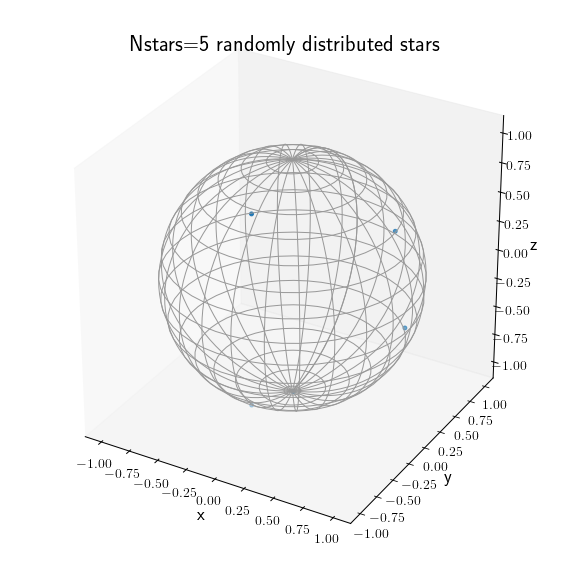

In [307]:
Nstars=5
x, y, z = populate_celestial_sphere(Nstars)


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

u = np.linspace(0, np.pi, 50)
v = np.linspace(0, 2 * np.pi, 50)

x0 = np.outer(np.sin(u), np.sin(v))
y0 = np.outer(np.sin(u), np.cos(v))
z0 = np.outer(np.cos(u), np.ones_like(v))


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x0, y0, z0, rstride=3, cstride=2, color='0.6', lw=1)

ax.scatter(x, y, z, s=15)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Nstars={} randomly distributed stars".format(Nstars))
plt.show()

In [309]:
c2 = SkyCoord(x, y, z, representation='cartesian')
xlon, xlat = c2.represent_as('spherical').lon.value, c2.represent_as('spherical').lat.value
#get_angular_separation(xlon[0], xlat[0], xlon[1], xlat[1])

angular_separations2 = []
for ii in range(Nstars-1):
    angsep = get_angular_separation(xlon[ii], xlat[ii], xlon[ii+1], xlat[ii+1]) * 180/np.pi
    angular_separations2.append(angsep)
    print("Ang sep [deg] btw. {} and {} = {:.2f}, slewing time [min] = {:.2f}".format(
            ii, ii+1, angsep, angsep/3.))
    
print("""==================================================================
      Total slew time [min] = {:.2f}""".format(np.array(angular_separations2).sum()/3.))

Ang sep [deg] btw. 0 and 1 = 87.56, slewing time [min] = 29.19
Ang sep [deg] btw. 1 and 2 = 121.04, slewing time [min] = 40.35
Ang sep [deg] btw. 2 and 3 = 82.79, slewing time [min] = 27.60
Ang sep [deg] btw. 3 and 4 = 92.96, slewing time [min] = 30.99
      Total slew time [min] = 128.11


# Science Times #

Now, compute the actual science time needed to measure masses of habitable zone Earth candidates. This includes exposure time per epoch & how many epochs needed to measure mass to 1$\sigma$

In [ ]:
# fn to compute the astrometric (proper motion + parallax) signal given a set of parameters

# fn to parse the set of parameters for fiducial targets

# fn to compute the integration time/epochs needed for astrometric signal

# fn to compute slew time

# fn to minimize slew time

In [8]:
def get_telescope_architecture(arch='A'):
    """Returns telescope diameter, effective area, 
    and exposure times (according to Mark Postman)"""
    if arch == 'A' or arch == 'a':
        return 15., 175., 300.
    else:
        return 8., 50., 1200.

def get_astrometric_amplitude(mp, ms, period, d):
    """Computes astrometric signal in micro-arcsec given planet & 
    stellar mass, period, and distance
    
    Parameters
    ----------
    mp : (float) mass of planet in Earth mass
    ms : (float) mass of host star in stellar mass
    period : (float) period of system in yr
    d : (float) distance of system in pc
    """
    return 3.* mp * ms**(-2./3) * period ** (2./3) / d

def get_photon_flux(mag, magsun=-26.74, fsun=3.8e21):
    """Computes the photon flux in photons per sec per square meters given apparent magnitude
    
    Parameters
    ----------
    mag : (float) apparent magnitude of object
    
    Optional
    --------
    magsun : (float) apparent magnitude of the sun (reference star)
    fsun : (float) photon flux of the sun (reference star)"""
    
    return fsun * 10**((mag-magsun)/-2.5)

def get_F0_AB(lam):
    """Returns flux in photons per sec per m^2 per Angstrom for 
    0th magnitude star in AB system
    
    Parameters
    ----------
    lam : (float) wavelength of bandpass in Angstrom
    
    From: https://github.com/tumlinson/luvoir_simtools/blob/master/hdi_etc/SNR_equation.pdf
    """
    return 5.5099e11/lam

def get_apparent_mag(d, abs_mag):
    """Computes apparent magnitude using distance modulus
    
    Parameters
    ----------
    d : (float) distance in parsecs
    abs_mag : (float) absolute magnitude of the object"""
    return 5.*np.log(d/10.) + abs_mag

def get_equivalent_flux(mag_star, F0=1., A_tel=175., qe=0.8):
    """Computes the equivalent flux in photons per sec (for astrometric accuracy)
    
    Parameters
    ----------
    mag_star : (float) magnitude of target star
    
    Optional
    --------
    F0 : (float) flux from 0th magnitude star in photons per sec
    A_tel : (float) total collecting area of telescope in m^2
    qe : (float) quantum efficiency of detector
    """
    return F0 * 10**(-.4*mag_star) * qe * A_tel
    
    
def get_astrometric_precision(Fequiv, t_exp, Nobs=1, lam=5500., d_tel=15.):
    """Computes the astrometric accuracy in radians PER epoch
    
    Parameters
    ----------
    Fequiv : (float) equivalent flux in photos per sec
    t_exp : (float) time of exposure in sec
    
    Optional
    ------
    Nobs : (int) number of observations
    lam : (float) wavelength of observation in angstrom
    d_tel : (float) diameter of telescope in m
    """
    return lam*1e-10 / (2.*d_tel) / np.sqrt(Nobs * t_exp * Fequiv)


def get_pm_error(sigma, Nepochs=2., dt=0.5):
    """Computes proper motion systematic error in arcseconds / yr
    
    Parameters
    ----------
    sigma : (float) astrometric accuracy
    
    Optional
    --------
    Nepochs : number of epochs (default=2)
    dt : (float) time btw. separate epochs in yr (default=0.5 yr)
    """
    return 206264.8 * (sigma * np.sqrt(2.) / dt) / np.sqrt(Nepochs-1.)

#def get_Nepochs(wobble, sigma, sigma dt=0.5):
#    return (wobble * dt / (206264.8 * sigma))**2

In [21]:
# Habitable zone calculations from Jake's notebook based on Kopparapu et al. (2013)
def calc_seff(Teff, S0, coeffs):
    a, b, c, d = coeffs
    T = Teff - 5780.
    return S0 + a*T + b*T**2 + c*T**3 + d*T**4

def calc_dist(L, Seff):
    return (L / Seff)**0.5

# Using the moist greenhouse inner edge
S0_inner = 1.0140
inner_edge = [8.1774e-5, 1.7063e-9, -4.3241e-12, -6.6462e-16]

# Using the maximum greenhouse outer edge
S0_outer = 0.3438
outer_edge = [5.8942e-5, 1.6558e-9, -3.0045e-12, -5.2983e-16]


def match_stellar_type(s, verbose = True):
    """
    Match stellar type ``s`` with the table of stellar types and return the index in table 
    that matches
    """
    for i, st in enumerate(stypes):
        if s == st:
            return i
    if verbose: print("No exact match found")
    for i, st in enumerate(stypes):
        if s.startswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s.endswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s+"V" == st:
            if verbose: print("Using %s for %s" %(st, s))
            return i

In [95]:
# Calculate the HZ of targets


# Read in table of stellar types
data = np.loadtxt('inputs/stellar_properties.txt', skiprows=19, dtype = str)

stypes = data[:,0] 
masses = np.array(data[:,1], dtype=float)
lums = np.array(data[:,2], dtype=float)
rads = np.array(data[:,3], dtype=float)
temps = np.array(data[:,4], dtype=float)
mvs = np.array(data[:,6], dtype=float)

a_in = np.zeros(Ndraw)
a_out = a_in*0.0
a_eeq = a_in*0.0
stellar_masses = a_in*0.0
#print(stellar_types)
for ii in range(len(idraw)):
    print("{}, {}".format(obj_names[ii], stellar_types[idraw[ii]]))
    imatch = match_stellar_type(stellar_types[idraw[ii]])
    stellar_masses[ii] = masses[imatch]
    print("Matched with {}".format(stypes[imatch]))
    a_in[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in[ii], a_out[ii]))
    a_eeq[ii] = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq[ii])

HIP19335, F7V
Matched with F7V
HZ limits : 1.57 - 2.62 au
Earth-Equivalent Insolation Distance : 1.62 au
HIP57757, F8V
Matched with F8V
HZ limits : 1.51 - 2.54 au
Earth-Equivalent Insolation Distance : 1.55 au
HIP116085, K2V
Matched with K2V
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
HIP48113, G2V
Matched with G2V
HZ limits : 1.10 - 1.89 au
Earth-Equivalent Insolation Distance : 1.11 au
HIP15371, G1V
Matched with G1V
HZ limits : 1.19 - 2.04 au
Earth-Equivalent Insolation Distance : 1.21 au


Photon flux [phot m^-2 s^-1] of 0th magnitude star (Vega): 76521521494.8
Arch A has d=15.0, A=175.0, t=300.0
Arch B has d=8.0, A=50.0, t=1200.0


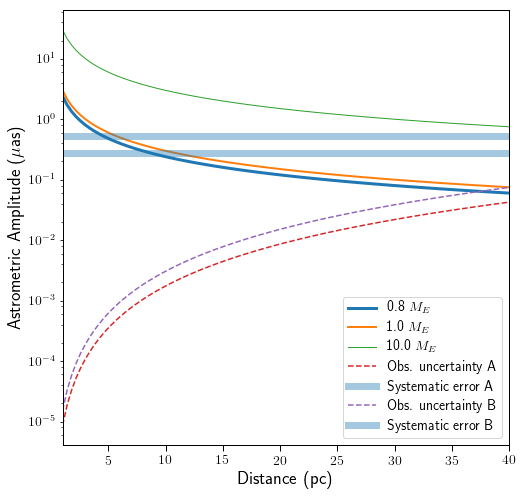

In [41]:
# Reproduce Mark Postman's plot for consistency check

d_test = np.linspace(1, 40, 100) # distance array
apparent_mags = get_apparent_mag(d_test, abs_mag=4.83) #apparent magnitude of sunlike star at different distances

sys_error = dict({'A':0.28, 'B': 0.53}) #micro-arcseconds
F0 = get_photon_flux(0.) #get flux [phot m^-2 s^-1] of 0th magnitude star
#F0 = 1000*5500.*1e4 #phot m^-2 s^-1
#F0 = get_F0_AB(5500.)
print("Photon flux [phot m^-2 s^-1] of 0th magnitude star (Vega): {}".format(F0))


ms = 1.0
mp = np.array([0.8, 1.0, 10.])

plt.figure(figsize=(8,8))
for ii in range(len(mp)):
    plt.plot(d_test, get_astrometric_amplitude(mp[ii], ms, 1.0, d_test), lw=3-ii, 
             label="{} $M_E$".format(mp[ii]))    
    
for arch in ['A', 'B']:
    dia, area, t_exp = get_telescope_architecture(arch)
    print("Arch {} has d={}, A={}, t={}".format(arch, dia, area, t_exp))
    f_equiv = get_equivalent_flux(apparent_mags, F0=F0, A_tel=area)
    sigmas = get_astrometric_precision(f_equiv, t_exp, d_tel=dia)
    pm_errors = get_pm_error(sigmas) * 1e6

    #plt.plot(d_test, sigmas*180/np.pi * 3600.*1e6, '--', label='single-epoch uncertainty')
    plt.plot(d_test, pm_errors, '--', label='Obs. uncertainty {}'.format(arch))
    plt.axhline(sys_error[arch], alpha=0.4, lw=7, label='Systematic error {}'.format(arch))
    #plt.plot(d_interesting, pm_errors_interesting*1e6, 'o')
plt.yscale('log')
plt.ylabel('Astrometric Amplitude ($\mu$as)')
plt.xlabel('Distance (pc)')
plt.xlim((d_test[0], d_test[-1]))
#plt.ylim((0.001, 100.))
plt.legend()

### Astrometric precision ###

The astrometric (positional) precision is related to the angular resolution and SNR achieved.

$\sigma = \frac{\theta}{2\mathrm{SNR}} = \left(\frac{\lambda}{2D_{tel}}\right) \frac{1}{\sqrt{N_{obs}t_{exp}}} \frac{1}{\sqrt{F_0 10^{(-0.4m_*)} A_{tel} QE}}$

Star		 Wobble (uas)	 Nepochs	 PM_err (uas/yr)	 sys_err (uas)
----------------------------------------------------------------------------------------
HIP19335	 0.1633		 10.5		 0.0010			 0.3748
HIP57757	 0.3259		 2.6		 0.0004			 0.3657
HIP116085	 0.1663		 10.2		 0.0017			 0.3573
HIP48113	 0.1750		 9.2		 0.0008			 0.3495
HIP15371	 0.2829		 3.5		 0.0008			 0.3421
----------------------------------------------------------------------------------------
Total Obs Time = Avg Nepochs x (tot slew per epoch + tot exp per epoch) 
                = 0.85 d
----------------------------------------------------------------------------------------
VS. Total Obs Time = 2.70 d if 58 targets with epochs tacked onto orbits observations


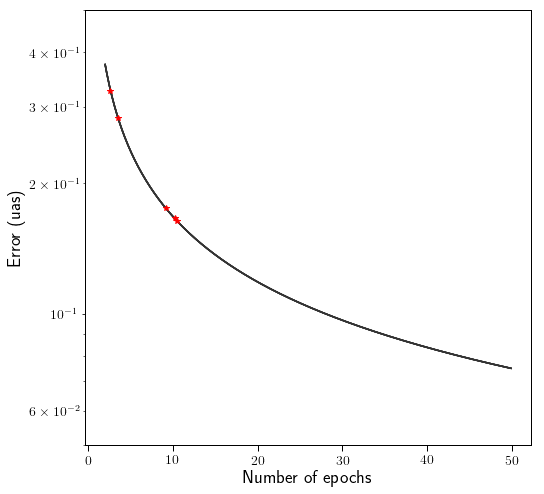

In [105]:
#d_interesting = np.array(result['Distance_distance'])
#print(stellar_distances[idraw], a_eeq)
mag_interesting = np.array(result['FLUX_V'])
wobble_interesting = get_astrometric_amplitude(mp[1], stellar_masses, a_eeq, stellar_distances[idraw])

plt.figure(figsize=(8,8))
f_equiv_interesting = get_equivalent_flux(mag_interesting, F0=F0, A_tel=area)
sigmas_interesting = get_astrometric_precision(f_equiv_interesting, t_exp, d_tel=dia)
Nepochs = np.arange(2, 50, 0.1)
epochs_needed = mag_interesting*0.0


print("""Star\t\t Wobble (uas)\t Nepochs\t PM_err (uas/yr)\t sys_err (uas)
----------------------------------------------------------------------------------------""")
for jj in range(len(sigmas_interesting)):
    pm_errors_interesting = get_pm_error(sigmas_interesting[jj], Nepochs=Nepochs, dt=2.) * 1e6
    sys_errors = sys_error[arch] / np.sqrt(Nepochs)
    tot_errors = np.sqrt(pm_errors_interesting**2 + sys_errors**2)
#Nepochs_interesting = get_Nepochs(wobble_interesting*1e-6, sigmas_interesting, dt=2.)
    plt.plot(Nepochs, pm_errors_interesting, label="{}".format(jj))
    plt.plot(Nepochs, tot_errors, '-', color='0.2')
    epochs_needed[jj] = Nepochs[np.argmin(abs(wobble_interesting[jj]-tot_errors))]

    print("{}\t {:.4f}\t\t {:.1f}\t\t {:.4f}\t\t\t {:.4f}".format(obj_names[jj], wobble_interesting[jj],
                                                                                         epochs_needed[jj],
                                                                                        pm_errors_interesting[jj], sys_errors[jj]))
plt.plot(epochs_needed, wobble_interesting, "r*")
plt.yscale('log')
plt.ylabel('Error (uas)')
plt.xlabel('Number of epochs')
#plt.legend()
plt.ylim((0.05, .5))



# assuming 100s exposures per epoch, avg # of epochs needed, and total slew time per epoch,
# the total telescope time needed is roughly (settling time not accounted for)
tot_time = np.nanmean(epochs_needed) * (300./60.*5 + 144.41) / 60. / 24.
#tot_time_58 = np.nanmean(epochs_needed) * (300./60.*58 + 10.*58) / 60. / 24.
print("""----------------------------------------------------------------------------------------
Total Obs Time = Avg Nepochs x (tot slew per epoch + tot exp per epoch) 
                = {:.2f} d""".format(tot_time))
print("""----------------------------------------------------------------------------------------
VS. Total Obs Time = {:.2f} d if 58 targets with epochs tacked onto orbits observations""".format(tot_time_58+.134))

### Moving Forward ###
- This analytic calculation vs. simulation+recovery (what Eduardo Bendek & Mark M. did; more robust)
- Settling time + system architecture specs (engineer Q)? 
- Exposure time calculator (although won't make too much of difference in final answer 10s or 1000s)
- This calculation assumed centroiding error is the noise floor, rather than some other systematic error (e.g., availability of comparison stars for bright targets to do relative astrometry, optical distortions) (Mark P seemed to only account for this in his DRM, but how can we justify this...?) **The number of epochs from this noise floor is at odds with what Mark M. described** 
- The time estimated is a pretty conservative estimate, since in realistic mission setting we'd be optimizing per target time

In [246]:
## Compute what the precision is if 6 epochs over 2 years 

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

(array([21.315 , 11.1203, 16.8768, 18.9038, 12.0464]),
 array([5.5 , 3.6 , 6.74, 5.1 , 5.24], dtype=float32))